In [1]:
!nvidia-smi

Sat Mar 22 16:39:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
%%capture
!pip install transformers accelerate bitsandbytes peft datasets huggingface_hub kagglehub

In [2]:
from huggingface_hub import login
from google.colab import userdata

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import torch
import wandb
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from transformers.integrations import WandbCallback
from datasets import Dataset, DatasetDict
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

In [4]:
login(token=userdata.get('HF_SECRET')) # login to HuggingFace
wb_token = userdata.get('WB_TOKEN')
!wandb login $wb_token

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [4]:
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [56]:
model.config.use_cache = False
model.gradient_checkpointing_enable()

In [15]:
dataset_path = kagglehub.dataset_download("kunalbhar/house-md-transcripts")
csv_files = [f"{dataset_path}/{f}" for f in os.listdir(dataset_path)]

print("Path to dataset files:", dataset_path)
print(os.listdir(dataset_path))

house_df = pd.DataFrame()

# Load transcripts from all seasons
for file in csv_files:
    df = pd.read_csv(file, encoding="latin-1")
    season_name = os.path.splitext(os.path.basename(file))[0]
    df["season"] = season_name
    house_df = pd.concat([house_df, df], ignore_index=True)

house_df.head()

Path to dataset files: /root/.cache/kagglehub/datasets/kunalbhar/house-md-transcripts/versions/2
['season8.csv', 'season3.csv', 'season4.csv', 'season7.csv', 'season5.csv', 'season1.csv', 'season6.csv', 'season2.csv']


,name,line,season
0,House,Pericardial effusion.,season8
1,Taub,Which wasn't there last night when we did the...,season8
2,Foreman,"She's getting worse, and there's no sign of a...",season8
3,Chase,Or maybe a cancer.,season8
4,Foreman,"We could use your opinion, House, or at least...",season8


<Figure size 1000x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

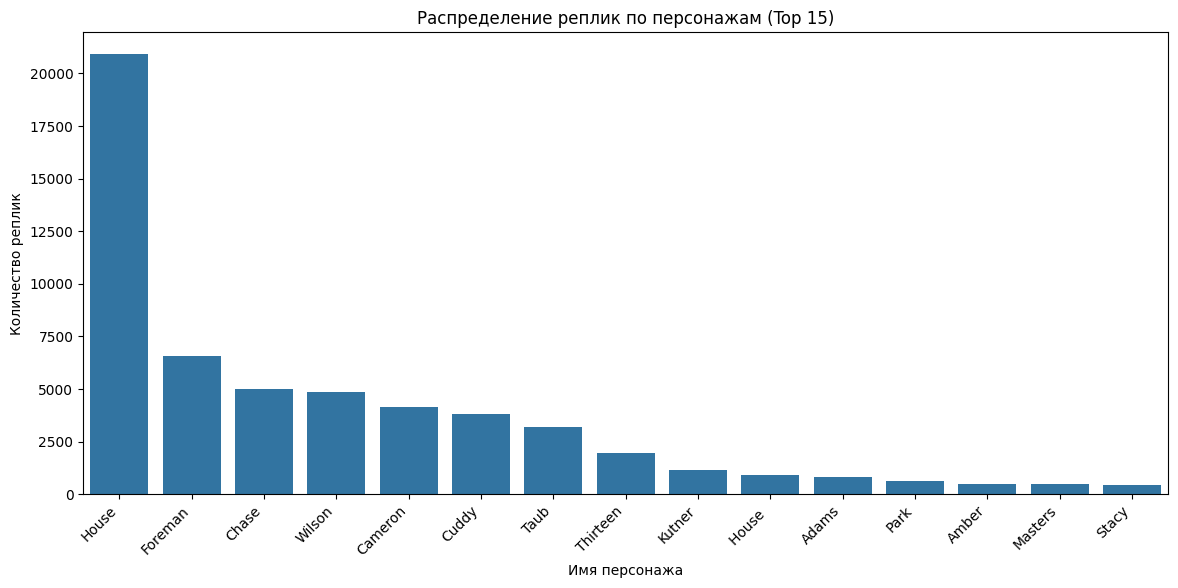

In [16]:
plt.figure(figsize=(10, 6))

hero_column = "name"

plt.figure(figsize=(12, 6))

line_counts = house_df.groupby("name")["line"].count().reset_index()
line_counts = line_counts.sort_values(by="line", ascending=False)

# Plot the distribution
plt.figure(figsize=(14, 6))
sns.barplot(data=line_counts, x="name", y="line", order=line_counts["name"][:15])

plt.xticks(rotation=45, ha="right")
plt.xlabel("Имя персонажа")
plt.ylabel("Количество реплик")
plt.title("Распределение реплик по персонажам (Top 15)")
plt.show()

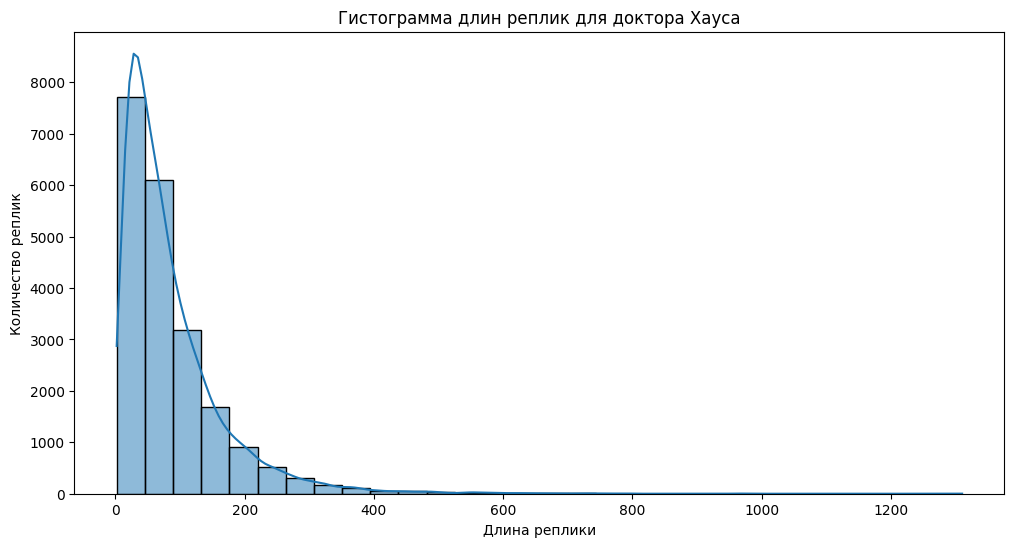

In [17]:
house_df_filtered = house_df[house_df["name"] == "House"]

house_lines = house_df_filtered["line"].astype(str)

house_lines_lengths = house_lines.str.len()

plt.figure(figsize=(12, 6))
sns.histplot(house_lines_lengths, bins=30, kde=True)

plt.xlabel("Длина реплики")
plt.ylabel("Количество реплик")
plt.title("Гистограмма длин реплик для доктора Хауса")
plt.show()

In [18]:
# Подготовими датасет на основе фрейма из реплик Хауса
def tokenize_function(examples):
  return tokenizer(examples["line"], padding="max_length", truncation=True)

house_df_filtered["line"] = house_df_filtered["line"].apply(lambda x: re.sub(r'[\[\(].*?[\]\)]', '', x))
full_dataset = Dataset.from_pandas(house_df_filtered[['line']])
full_dataset = full_dataset.map(tokenize_function, batched=True)

# обойдемся без валидации тк быстрый тест LoRA на маленьком датасете
dataset = full_dataset.train_test_split(test_size=0.1, seed=42)
print(dataset)

<ipython-input-18-8d9a1298fe1c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df_filtered["line"] = house_df_filtered["line"].apply(lambda x: re.sub(r'[\[\(].*?[\]\)]', '', x))


Map:   0%|          | 0/20908 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['line', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 18817
    })
    test: Dataset({
        features: ['line', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 2091
    })
})


In [57]:
target_modules = ["q_proj", "v_proj"]
# target_modules = ["q_proj", "v_proj", "k_proj", "o_proj"]
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=target_modules,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

# Обернем базовую модель с LoRA адаптером
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 1,126,400 || all params: 1,101,174,784 || trainable%: 0.1023


In [58]:
wandb.init(project="LLM-House-LoRA")

training_args = TrainingArguments(
    output_dir="pth-house-lora",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    num_train_epochs=3,
    learning_rate=2e-4,
    fp16=False,
    bf16=True,
    optim="paged_adamw_8bit",
    logging_steps=200,
    evaluation_strategy="no",
    save_strategy="epoch",
    report_to="wandb",
    warmup_steps=100,
    weight_decay=0.01,
    max_grad_norm=1.0
)

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset.get("test", None),
    args=training_args,
    data_collator=data_collator,
    tokenizer=tokenizer
)

trainer.add_callback(WandbCallback())

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-58-e6ee0fb71836>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
You are adding a <class 'transformers.integrations.integration_utils.WandbCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
WandbCallback
NotebookProgressCallback


In [59]:
trainer.train()
wandb.finish()

Step,Training Loss
200,3.055500
400,2.784800
600,2.771300
800,2.734200
1000,2.729900
1200,2.715300
1400,2.694800
1600,2.670500
1800,2.666600
2000,2.667800


/usr/local/lib/python3.11/dist-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 351c1be2-35c8-448b-8110-84dc5139c49d)') - silently ignoring the lookup for the file config.json in TinyLlama/TinyLlama-1.1B-Chat-v1.0.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in TinyLlama/TinyLlama-1.1B-Chat-v1.0 - will assume that the vocabulary was not modified.
  warnings.warn(


train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
train/grad_norm,▆▆██▂▂▃▃▆▆▆▆▂▂▃▃▁▁▆▆▁▁▃▃▅▅▆▆▂▂▅▅▅▅
train/learning_rate,████▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
train/loss,██▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
total_flos,7.183914393057362e+17
train/epoch,3
train/global_step,3531
train/grad_norm,1.72237
train/learning_rate,1e-05
train/loss,2.6399


In [6]:
def generate_reply(prompt, max_new_tokens=50):
    inputs = tokenizer(prompt, return_tensors='pt').to("cuda")
    outputs = model.generate(**inputs,
                              pad_token_id=tokenizer.eos_token_id,
                              eos_token_id=tokenizer.eos_token_id,
                              do_sample=True,
                              temperature=0.7,
                              top_p=0.9,
                              top_k=50,
                              repetition_penalty=1.2,
                              max_length=inputs["input_ids"].shape[1] + max_new_tokens,
                              early_stopping=True
                             )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    if response.startswith(prompt):
        response = response[len(prompt):].strip()

    return response

In [8]:
generate_reply("What could you suggest to avoid depression?")

"I think I've done enough for this evening. If I were to keep talking, it would be a different story. But the truth is that, after all these years of being in love with you and not doing anything about it, we"

In [9]:
generate_reply("I need my painkiller")

". You're going to be fine, but we have to go back and make sure they didn't leave any evidence behind. And if you don't want me to tell them what happened then don't listen to them either! If"

In [10]:
generate_reply("What did you say to your patient?")

"Did she have a heart attack or a stroke, what was it?\n\nPatient: She had a pulmonary embolism. Her lungs were filled with clots and she couldn't breathe. I didn't"

In [67]:
generate_reply("How are you?")

"A: (nodding) I'm fine. Just a little bored, which is why I was looking for something to do this afternoon. What did you want me to look at?\nB: (pause) You know"

In [54]:
torch.cuda.empty_cache()
del model

In [68]:
merged_model = model.merge_and_unload()
merged_model.save_pretrained("tiny-llama-house-merged")
tokenizer.save_pretrained("tiny-llama-house-merged")

('tiny-llama-house-merged/tokenizer_config.json',
 'tiny-llama-house-merged/special_tokens_map.json',
 'tiny-llama-house-merged/tokenizer.model',
 'tiny-llama-house-merged/added_tokens.json',
 'tiny-llama-house-merged/tokenizer.json')

In [70]:
torch.save(merged_model.state_dict(), "llama-model.pt")